<a href="https://colab.research.google.com/github/muhammetsnts/SPARK_NLP/blob/master/projects/2.Named_Entity_Recognition_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  1. NER Model Implementation in Spark NLP

  The deep neural network architecture for NER model in
Spark NLP is BiLSTM-CNN-Char framework. a slightly modified version of the architecture proposed by Jason PC Chiu and Eric Nichols ([Named Entity Recognition with Bidirectional LSTM-CNNs
](https://arxiv.org/abs/1511.08308)). It is a neural network architecture that
automatically detects word and character-level features using a
hybrid bidirectional LSTM and CNN architecture, eliminating
the need for most feature engineering steps.

  In the original framework, the CNN extracts a fixed length
feature vector from character-level features. For each word,
these vectors are concatenated and fed to the BLSTM network
and then to the output layers. They employed a stacked
bi-directional recurrent neural network with long short-term
memory units to transform word features into named entity
tag scores. The extracted features of each word are fed into a
forward LSTM network and a backward LSTM network. The
output of each network at each time step is decoded by a linear
layer and a log-softmax layer into log-probabilities for each tag
category. These two vectors are then simply added together to
produce the final output. In the architecture of the proposed framework in the original paper, 50-dimensional pretrained word
embeddings is used for word features, 25-dimension character
embeddings is used for char features, and capitalization features
(allCaps, upperInitial, lowercase, mixedCaps, noinfo) are used
for case features.

## 2. Colab Setup

In [1]:
import json
import os

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

Saving 3.4.0.spark_nlp_for_healthcare.txt to 3.4.0.spark_nlp_for_healthcare.txt


In [2]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

     |████████████████████████████████| 212.4 MB 71 kB/s 
     |████████████████████████████████| 198 kB 62.2 MB/s 
     |████████████████████████████████| 144 kB 7.1 MB/s 
     |████████████████████████████████| 140 kB 7.0 MB/s 
     |████████████████████████████████| 95 kB 2.1 MB/s 
     |████████████████████████████████| 66 kB 4.2 MB/s 


In [3]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 3.4.0
Spark NLP_JSL Version : 3.4.0


# Download NCBI Disease Dataset

In [4]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltrain.txt
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltest.txt

Read the datasets by using CoNLL reader.

In [5]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'NER_NCBIconlltrain.txt')

conll_data.show(5, truncate=30)

+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                          text|                      document|                      sentence|                         token|                           pos|                         label|
+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|Identification of APC2 , a ...|[{document, 0, 89, Identifi...|[{document, 0, 89, Identifi...|[{token, 0, 13, Identificat...|[{pos, 0, 13, NN, {word -> ...|[{named_entity, 0, 13, O, {...|
|The adenomatous polyposis c...|[{document, 0, 211, The ade...|[{document, 0, 211, The ade...|[{token, 0, 2, The, {senten...|[{pos, 0, 2, NN, {word -> T...|[{named_entity, 0, 2, O, {w...|
|Complex formation induces t...|[{document, 0, 63, Complex .

In [6]:
conll_data.count()

3266

In [7]:
from pyspark.sql import functions as F

conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .show(50,truncate=False)


+--------------+------------+
|token         |ground_truth|
+--------------+------------+
|Identification|O           |
|of            |O           |
|APC2          |O           |
|,             |O           |
|a             |O           |
|homologue     |O           |
|of            |O           |
|the           |O           |
|adenomatous   |B-Disease   |
|polyposis     |I-Disease   |
|coli          |I-Disease   |
|tumour        |I-Disease   |
|suppressor    |O           |
|.             |O           |
|The           |O           |
|adenomatous   |B-Disease   |
|polyposis     |I-Disease   |
|coli          |I-Disease   |
|(             |I-Disease   |
|APC           |I-Disease   |
|)             |I-Disease   |
|tumour        |I-Disease   |
|-             |O           |
|suppressor    |O           |
|protein       |O           |
|controls      |O           |
|the           |O           |
|Wnt           |O           |
|signalling    |O           |
|pathway       |O           |
|by       

Lets count the labels in the dataset.

In [8]:
conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(truncate=False)


+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |75093|
|I-Disease   |3547 |
|B-Disease   |3093 |
+------------+-----+



**As you can see there are too many O labels. So we will trim the sentences contains only O label.**

In [9]:
conll_data.select("label.result").distinct().count()

1537

In [10]:
conll_data = conll_data.withColumn('unique', F.array_distinct("label.result"))\
                       .withColumn('c', F.size('unique'))\
                       .filter(F.col('c')>1)

In [11]:
conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |39427|
|I-Disease   |3547 |
|B-Disease   |3093 |
+------------+-----+



Now we trimmed nearly the half of the O labels. Lets continue with reading test data.

In [12]:
test_data = CoNLL().readDataset(spark, 'NER_NCBIconlltest.txt')
test_data.show(5, truncate=30)

+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                          text|                      document|                      sentence|                         token|                           pos|                         label|
+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|Clustering of missense muta...|[{document, 0, 102, Cluster...|[{document, 0, 102, Cluster...|[{token, 0, 9, Clustering, ...|[{pos, 0, 9, NN, {word -> C...|[{named_entity, 0, 9, O, {w...|
|Ataxia - telangiectasia ( A...|[{document, 0, 136, Ataxia ...|[{document, 0, 136, Ataxia ...|[{token, 0, 5, Ataxia, {sen...|[{pos, 0, 5, NN, {word -> A...|[{named_entity, 0, 5, B-Dis...|
|The risk of cancer , especi...|[{document, 0, 156, The ris.

Check the label counts of test data.

In [13]:
test_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |16804|
|I-Disease   |789  |
|B-Disease   |708  |
+------------+-----+



We will use `embeddings_clinical` clinical word embeddings model for vectorizing the tokens.

In [14]:
# Clinical word embeddings trained on PubMED dataset
clinical_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [15]:
test_data = clinical_embeddings.transform(test_data)

test_data.write.parquet('NER_NCBIconlltest.parquet')

### NERDL Graph
TensorFlow graph file (`.pb` extension) should be produced for NER training.

In [16]:
from sparknlp_jsl.training import tf_graph
%tensorflow_version 1.x
tf_graph.print_model_params("ner_dl")

tf_graph.build("ner_dl", 
               build_params={"embeddings_dim": 200, 
                             "nchars": 83, 
                             "ntags": 12, 
                             "is_medical": 0}, 
               model_location="./medical_ner_graphs", 
               model_filename="auto")

TensorFlow 1.x selected.
ner_dl parameters.
Parameter            Required   Default value        Description
ntags                yes        -                    Number of tags.
embeddings_dim       no         200                  Embeddings dimension.
nchars               no         100                  Number of chars.
lstm_size            no         128                  Number of LSTM units.
gpu_device           no         0                    Device for training.
is_medical           no         0                    Build a Medical Ner graph.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
non-resource variables are not supported in the long term

## Attempt -1


In [ ]:
nerTagger = MedicalNerApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(20)\
      .setLr(1)\
      .setBatchSize(64)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setValidationSplit(0.2)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setOutputLogsPath('ner_logs')\
      .setGraphFolder('medical_ner_graphs')\
      .setEnableMemoryOptimizer(True)\
      .setTestDataset("NER_NCBIconlltest.parquet")

In [ ]:
ner_pipeline = Pipeline(stages=[
          clinical_embeddings,
          nerTagger
          ])

Fit the model.

In [ ]:
%%time

ner_model = ner_pipeline.fit(conll_data)

CPU times: user 8.86 s, sys: 1.38 s, total: 10.2 s
Wall time: 23min 58s


Saving the model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ner_model.stages[1].write().overwrite().save('/content/drive/MyDrive/YL/models/NER_20epoch_64b')

`getTrainingClassDistribution()` parameter returns the distribution of labels used when training the NER model.

In [ ]:
ner_model.stages[1].getTrainingClassDistribution()

{'O': 31617, 'B-Disease': 2479, 'I-Disease': 2816}

Let's check the results saved in the log file

In [ ]:
import os 
log_file= os.listdir("ner_logs")[0]

with open (f"./ner_logs/{log_file}") as f:
  print(f.read())

Name of the selected graph: /content/medical_ner_graphs/blstm_12_200_128_83.pb
Training started - total epochs: 20 - lr: 0.001 - batch size: 64 - labels: 3 - chars: 82 - training examples: 1357


Epoch 1/20 started, lr: 0.001, dataset size: 1357


Epoch 1/20 - 60.13s - loss: 353.53445 - avg training loss: 16.069748 - batches: 22
Quality on validation dataset (20.0%), validation examples = 271
time to finish evaluation: 8.63s
Total validation loss: 48.8593	Avg validation loss: 8.1432
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 80	 3	 651	 0.96385545	 0.10943913	 0.19656022
B-Disease	 86	 55	 528	 0.6099291	 0.14006515	 0.22781458
tp: 166 fp: 58 fn: 1179 labels: 2
Macro-average	 prec: 0.7868923, rec: 0.124752134, f1: 0.21536136
Micro-average	 prec: 0.7410714, rec: 0.123420075, f1: 0.21159975
Quality on test dataset: 
time to finish evaluation: 10.48s
Total test loss: 56.0021	Avg test loss: 5.0911
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 56	 7	 733	 0.8888889	 0.07097592	 0.1314554
B-D

### Plotting Logs

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

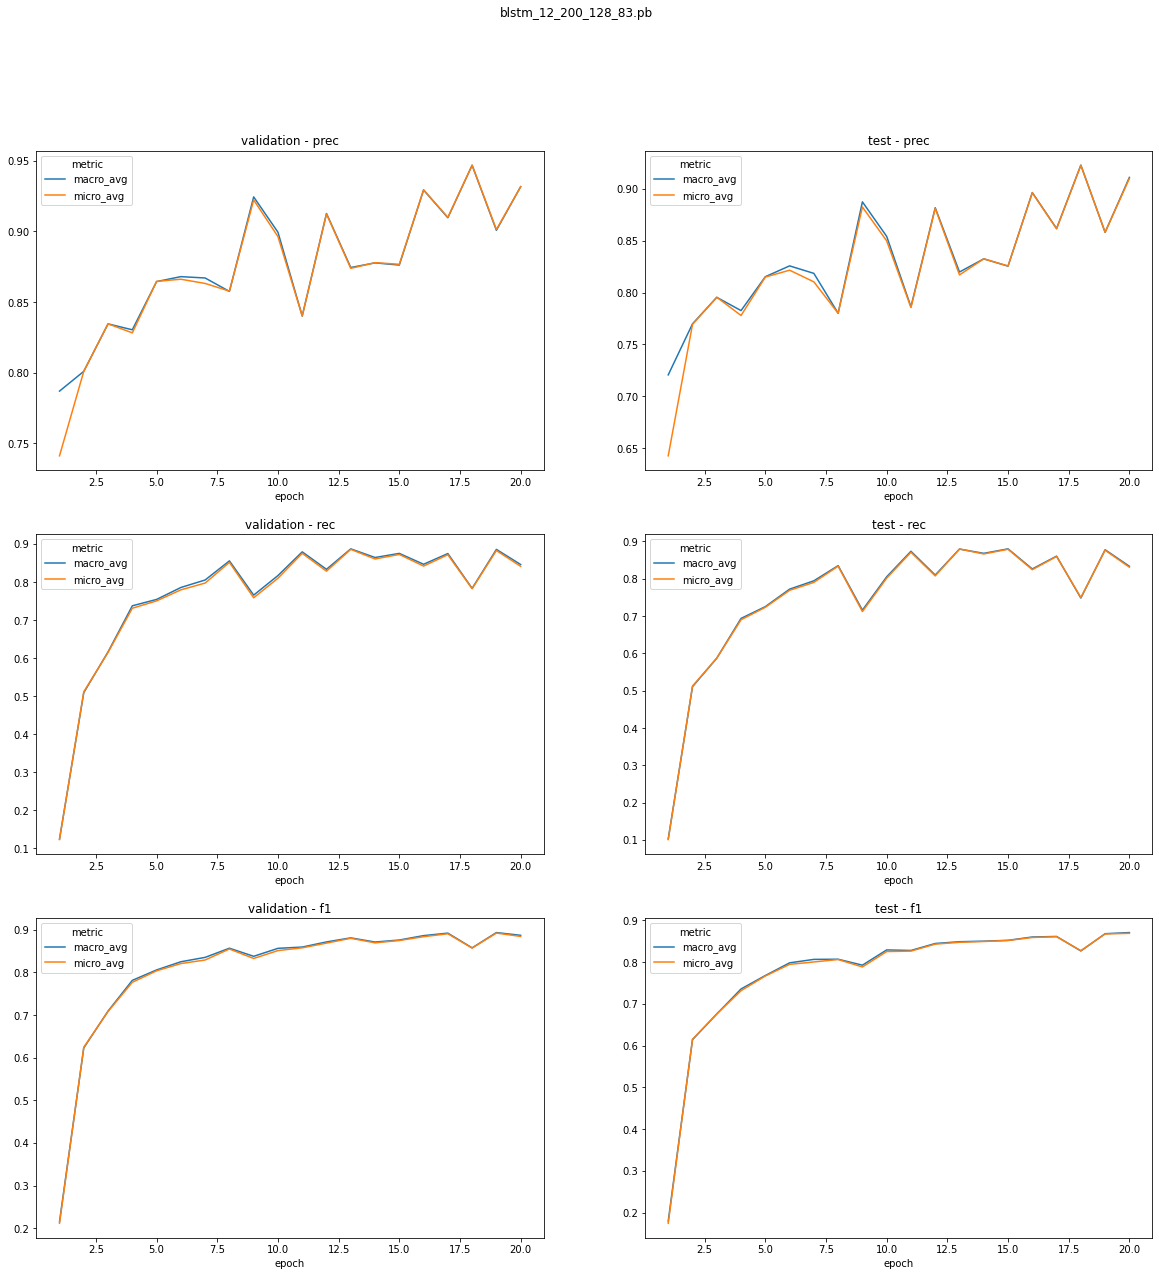

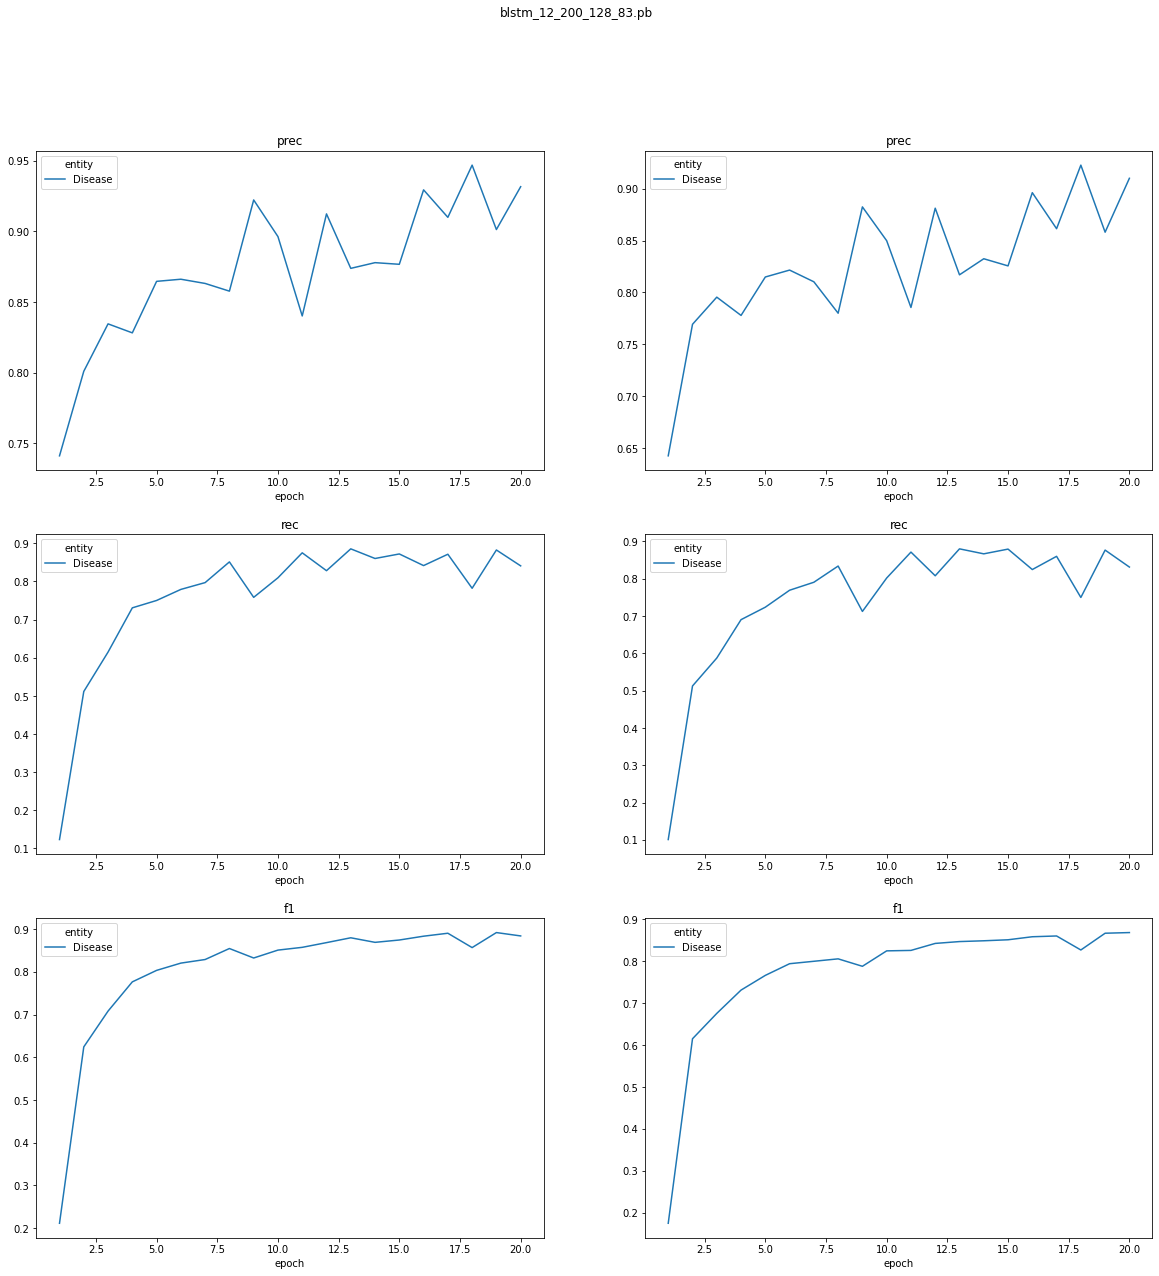

In [ ]:
import ner_log_parser
%matplotlib inline
ner_log_parser.get_charts(f"./ner_logs/{log_file}")


### Plotting Loss

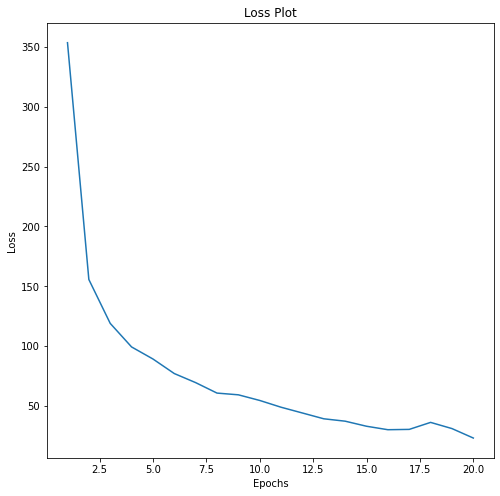

In [ ]:
ner_log_parser.loss_plot(f"./ner_logs/{log_file}")

### Evaluate Model

In [ ]:
pred_df = ner_model.stages[1].transform(test_data)

In [ ]:
pred_df.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

First we will evaluate by full_chunk.

In [ ]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

evaler = NerDLMetrics(mode="full_chunk", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+-----+-----+-----+-----+---------+------+------+
| entity|   tp|   fp|   fn|total|precision|recall|    f1|
+-------+-----+-----+-----+-----+---------+------+------+
|Disease|598.0|122.0|106.0|704.0|   0.8306|0.8494|0.8399|
+-------+-----+-----+-----+-----+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8398876404494382|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.8398876404494383|
+------------------+

None


Now we will evaluate by partial chunk.

In [ ]:
evaler = NerDLMetrics(mode="partial_chunk_per_token", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+------+----+-----+------+---------+------+-----+
| entity|    tp|  fp|   fn| total|precision|recall|   f1|
+-------+------+----+-----+------+---------+------+-----+
|Disease|1285.0|83.0|212.0|1497.0|   0.9393|0.8584|0.897|
+-------+------+----+-----+------+---------+------+-----+

+------------------+
|             macro|
+------------------+
|0.8970331588132635|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.8970331588132635|
+------------------+

None


As you can see the full_chunk F1 score is lower than the partial_chunk F1 score as expected. Lets check classification report.

In [ ]:
from sklearn.metrics import classification_report

predictions = pred_df.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(predictions['ground_truth'], predictions['prediction'], digits=4))

              precision    recall  f1-score   support

   B-Disease     0.8798    0.8785    0.8792       708
   I-Disease     0.9410    0.7883    0.8579       789
           O     0.9875    0.9951    0.9913     16804

    accuracy                         0.9816     18301
   macro avg     0.9361    0.8873    0.9094     18301
weighted avg     0.9813    0.9816    0.9812     18301



## Attempt -2


In [ ]:
nerTagger = MedicalNerApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(30)\
      .setLr(0.003)\
      .setBatchSize(16)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setValidationSplit(0.2)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setOutputLogsPath('ner_logs')\
      .setGraphFolder('medical_ner_graphs')\
      .setEnableMemoryOptimizer(True)\
      .setTestDataset("NER_NCBIconlltest.parquet")

In [ ]:
ner_pipeline = Pipeline(stages=[
          clinical_embeddings,
          nerTagger
          ])

In [ ]:
%%time

ner_model = ner_pipeline.fit(conll_data)

CPU times: user 14.9 s, sys: 2.19 s, total: 17.1 s
Wall time: 39min 30s


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ner_model.stages[1].write().overwrite().save('/content/drive/MyDrive/YL/models/NER_30epoch_16b_3lr')

In [ ]:
ner_model.stages[1].getTrainingClassDistribution()

{'B-Disease': 2488, 'I-Disease': 2900, 'O': 31099}

Let's check the results saved in the log file

In [ ]:
import os 
log_file= os.listdir("ner_logs")[0]

with open (f"./ner_logs/{log_file}") as f:
  print(f.read())

Name of the selected graph: /content/medical_ner_graphs/blstm_12_200_128_83.pb
Training started - total epochs: 30 - lr: 0.003 - batch size: 16 - labels: 3 - chars: 82 - training examples: 1356


Epoch 1/30 started, lr: 0.003, dataset size: 1356


Epoch 1/30 - 65.90s - loss: 941.96423 - avg training loss: 11.081932 - batches: 85
Quality on validation dataset (20.0%), validation examples = 271
time to finish evaluation: 9.14s
Total validation loss: 93.5725	Avg validation loss: 4.2533
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 346	 59	 301	 0.854321	 0.5347759	 0.65779465
B-Disease	 448	 123	 157	 0.78458846	 0.74049586	 0.76190484
tp: 794 fp: 182 fn: 458 labels: 2
Macro-average	 prec: 0.8194547, rec: 0.6376359, f1: 0.7172015
Micro-average	 prec: 0.8135246, rec: 0.6341853, f1: 0.71274686
Quality on test dataset: 
time to finish evaluation: 9.91s
Total test loss: 125.2178	Avg test loss: 2.8459
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 411	 80	 378	 0.8370672	 0.5209125	 0.6421875
B-Dis

### Plotting Logs

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

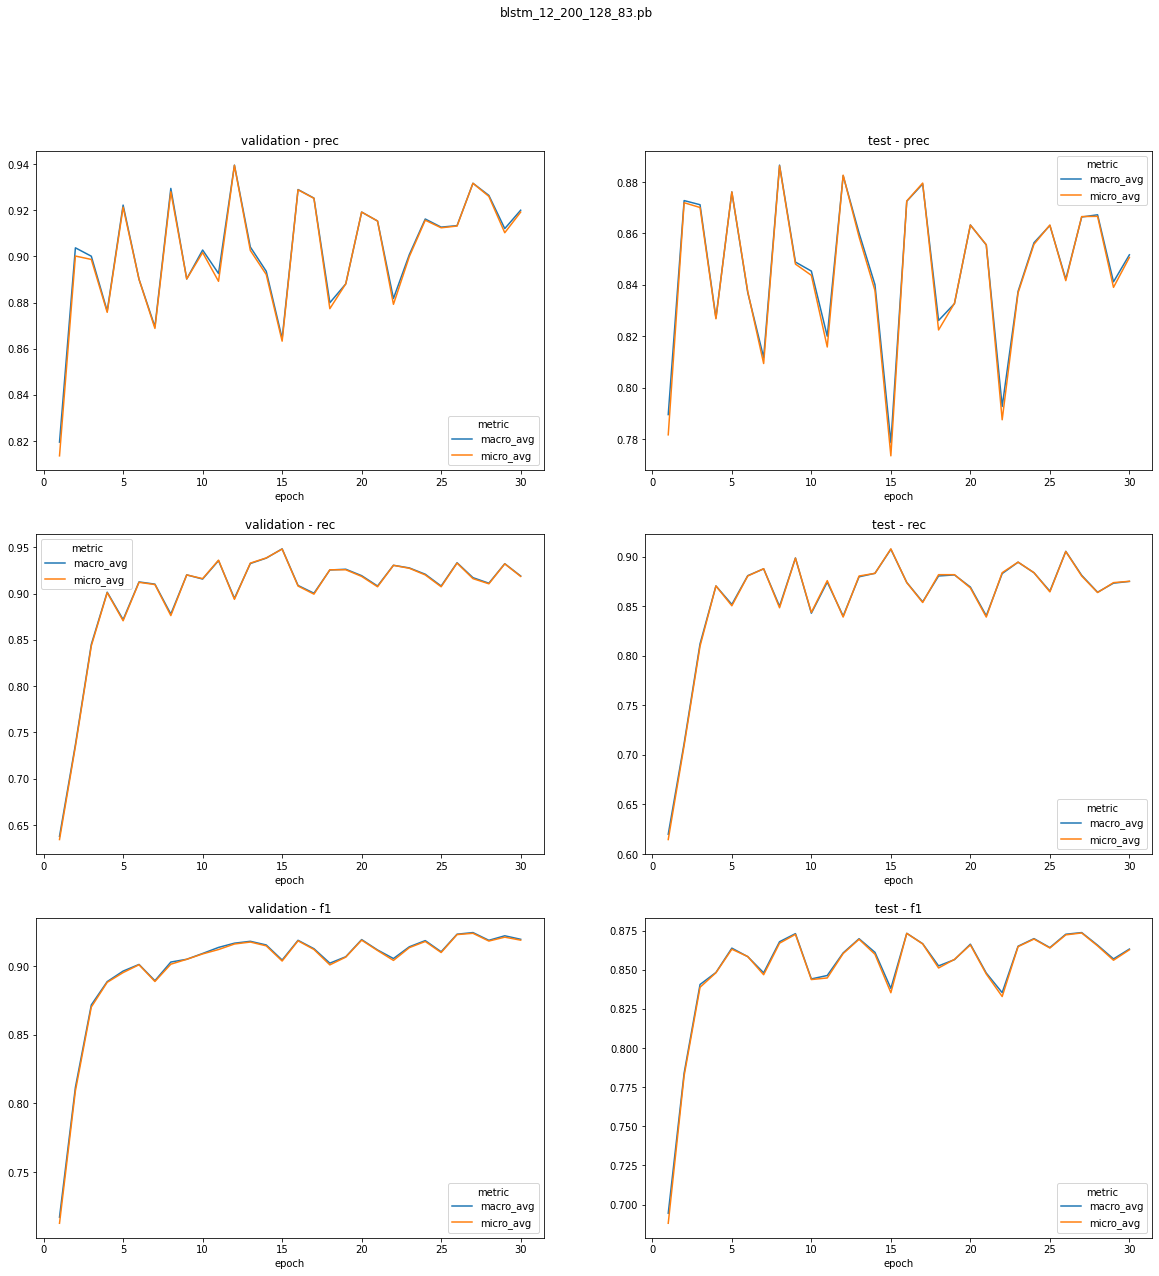

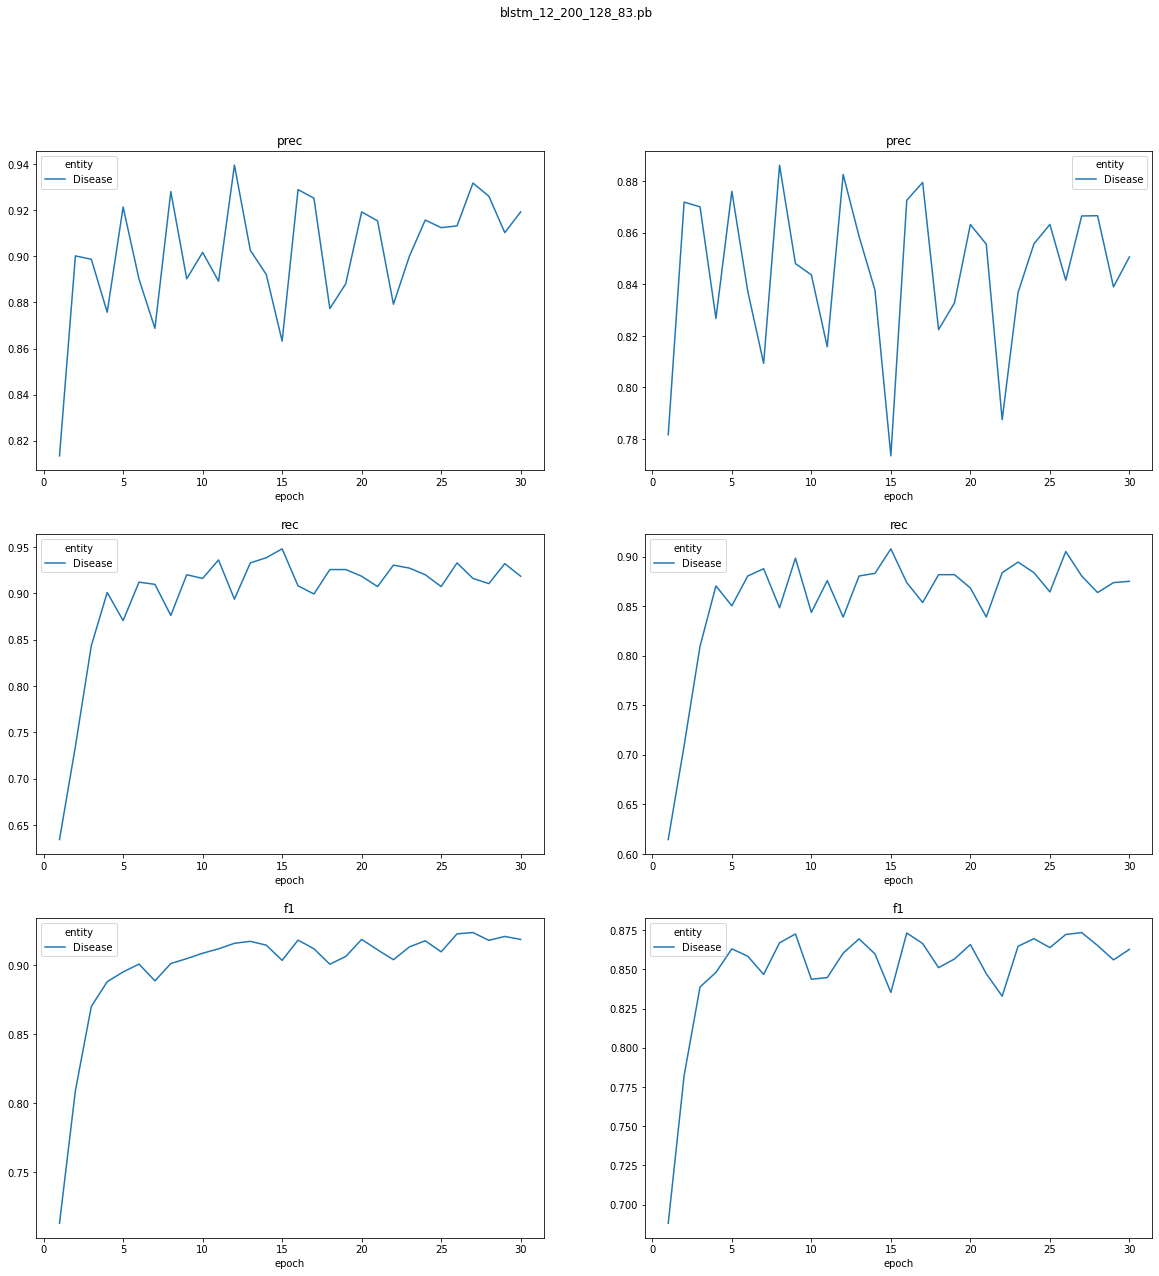

In [ ]:
import ner_log_parser
%matplotlib inline
ner_log_parser.get_charts(f"./ner_logs/{log_file}")


### Plotting Loss

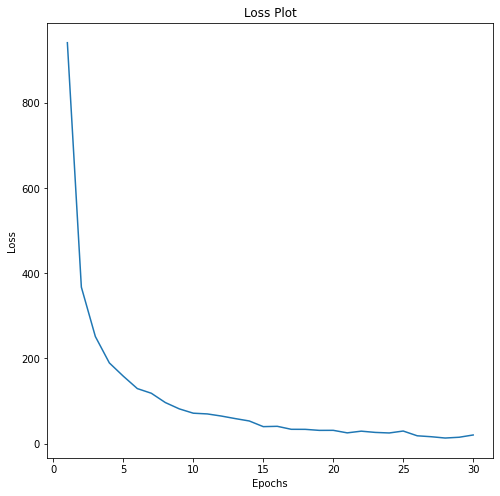

In [ ]:
ner_log_parser.loss_plot(f"./ner_logs/{log_file}")

### Evaluate Model

In [ ]:
pred_df = ner_model.stages[1].transform(test_data)

In [ ]:
pred_df.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

In [ ]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

evaler = NerDLMetrics(mode="full_chunk", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+-----+-----+-----+-----+---------+------+------+
| entity|   tp|   fp|   fn|total|precision|recall|    f1|
+-------+-----+-----+-----+-----+---------+------+------+
|Disease|591.0|120.0|113.0|704.0|   0.8312|0.8395|0.8353|
+-------+-----+-----+-----+-----+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8353356890459364|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.8353356890459364|
+------------------+

None


In [ ]:
evaler = NerDLMetrics(mode="partial_chunk_per_token", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+------+-----+-----+------+---------+------+------+
| entity|    tp|   fp|   fn| total|precision|recall|    f1|
+-------+------+-----+-----+------+---------+------+------+
|Disease|1367.0|168.0|130.0|1497.0|   0.8906|0.9132|0.9017|
+-------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.9017150395778364|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.9017150395778364|
+------------------+

None


In [ ]:
from sklearn.metrics import classification_report

predictions = pred_df.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(predictions['ground_truth'], predictions['prediction'], digits=4))

              precision    recall  f1-score   support

   B-Disease     0.8655    0.8729    0.8692       708
   I-Disease     0.8429    0.8771    0.8596       789
           O     0.9922    0.9900    0.9911     16804

    accuracy                         0.9806     18301
   macro avg     0.9002    0.9133    0.9066     18301
weighted avg     0.9809    0.9806    0.9807     18301



## Attempt -3


In [19]:
nerTagger = NerDLApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(30)\
      .setLr(0.0003)\
      .setBatchSize(32)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setValidationSplit(0.2)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setOutputLogsPath('ner_logs')\
      .setGraphFolder('medical_ner_graphs')\
      .setEnableMemoryOptimizer(True)\
      .setTestDataset("NER_NCBIconlltest.parquet")\
      .setUseBestModel(True)

In [20]:
ner_pipeline = Pipeline(stages=[
          clinical_embeddings,
          nerTagger
          ])

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
%%time

ner_model = ner_pipeline.fit(conll_data)

CPU times: user 13.2 s, sys: 1.93 s, total: 15.2 s
Wall time: 36min 19s


In [23]:
ner_model.stages[1].write().overwrite().save('/content/drive/MyDrive/YL/models/NER_30epoch_16b_03lr')

Let's check the results saved in the log file

In [25]:
import os 
log_file= os.listdir("ner_logs")[0]

with open (f"./ner_logs/{log_file}") as f:
  print(f.read())

Name of the selected graph: /content/medical_ner_graphs/blstm_12_200_128_83.pb
Training started - total epochs: 30 - lr: 3.0E-4 - batch size: 32 - labels: 3 - chars: 80 - training examples: 1358


Epoch 1/30 started, lr: 3.0E-4, dataset size: 1358


Epoch 1/30 - 59.72s - loss: 826.8634 - batches: 43
Quality on validation dataset (20.0%), validation examples = 271
time to finish evaluation: 8.44s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 81	 11	 605	 0.8804348	 0.1180758	 0.20822623
B-Disease	 15	 9	 618	 0.625	 0.023696683	 0.045662105
tp: 96 fp: 20 fn: 1223 labels: 2
Macro-average	 prec: 0.7527174, rec: 0.07088624, f1: 0.12957035
Micro-average	 prec: 0.82758623, rec: 0.07278241, f1: 0.13379791
Quality on test dataset: 
time to finish evaluation: 9.65s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 65	 18	 724	 0.78313255	 0.08238276	 0.14908256
B-Disease	 13	 9	 695	 0.59090906	 0.018361581	 0.03561644
tp: 78 fp: 27 fn: 1419 labels: 2
Macro-average	 prec: 0.6870208, rec: 0.050372172, f

### Plotting Logs

In [26]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

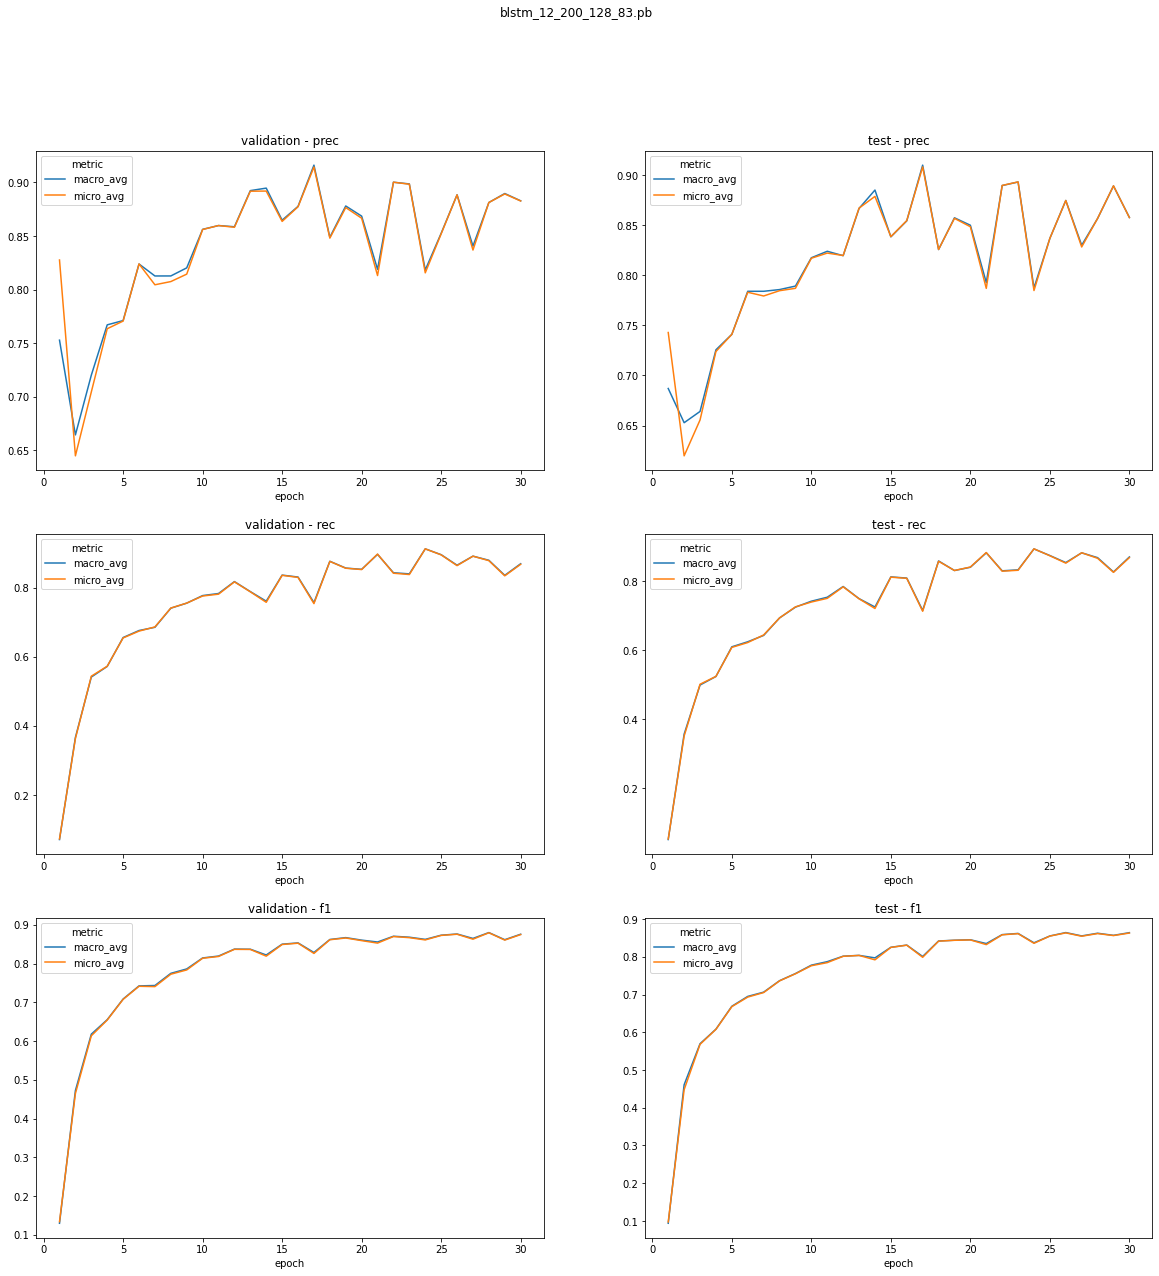

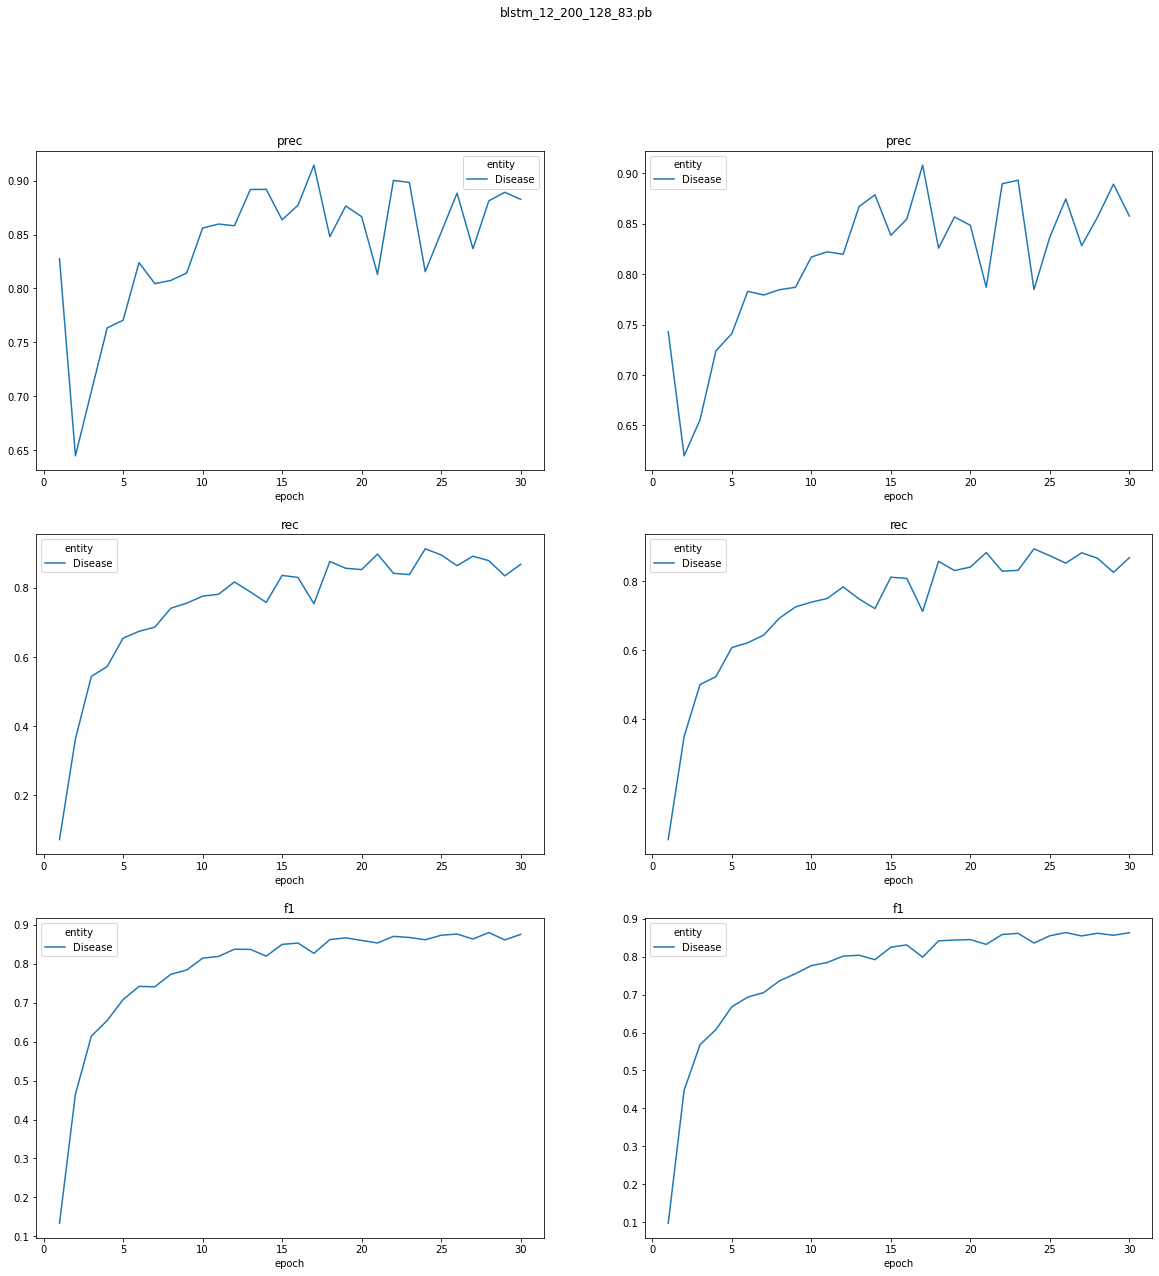

In [27]:
import ner_log_parser
%matplotlib inline
ner_log_parser.get_charts(f"./ner_logs/{log_file}")


### Plotting Loss

In [ ]:
ner_log_parser.loss_plot(f"./ner_logs/{log_file}")

### Evaluate Model

In [19]:
ner_model = NerDLModel.load("/content/drive/MyDrive/YL/models/NER_30epoch_16b_03lr")

In [20]:
pred_df = ner_model.transform(test_data)

In [21]:
pred_df.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

In [22]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

evaler = NerDLMetrics(mode="full_chunk", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+-----+-----+-----+-----+---------+------+------+
| entity|   tp|   fp|   fn|total|precision|recall|    f1|
+-------+-----+-----+-----+-----+---------+------+------+
|Disease|592.0|151.0|112.0|704.0|   0.7968|0.8409|0.8182|
+-------+-----+-----+-----+-----+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8182446440912232|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.8182446440912231|
+------------------+

None


In [23]:
evaler = NerDLMetrics(mode="partial_chunk_per_token", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+------+-----+-----+------+---------+------+------+
| entity|    tp|   fp|   fn| total|precision|recall|    f1|
+-------+------+-----+-----+------+---------+------+------+
|Disease|1329.0|130.0|168.0|1497.0|   0.9109|0.8878|0.8992|
+-------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8991880920162382|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.8991880920162381|
+------------------+

None


In [24]:
from sklearn.metrics import classification_report

predictions = pred_df.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(predictions['ground_truth'], predictions['prediction'], digits=4))

              precision    recall  f1-score   support

   B-Disease     0.8575    0.8842    0.8707       708
   I-Disease     0.8916    0.8238    0.8564       789
           O     0.9900    0.9923    0.9911     16804

    accuracy                         0.9808     18301
   macro avg     0.9131    0.9001    0.9061     18301
weighted avg     0.9807    0.9808    0.9807     18301



## Attempt -4



In [17]:
nerTagger = NerDLApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(30)\
      .setLr(0.1)\
      .setBatchSize(64)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setValidationSplit(0.2)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setOutputLogsPath('ner_logs')\
      .setGraphFolder('medical_ner_graphs')\
      .setEnableMemoryOptimizer(True)\
      .setTestDataset("NER_NCBIconlltest.parquet")\
      .setUseBestModel(True)\
      .setUseContrib(True)

In [18]:
ner_pipeline = Pipeline(stages=[
          clinical_embeddings,
          nerTagger
          ])

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
%%time

ner_model = ner_pipeline.fit(conll_data)

CPU times: user 11.7 s, sys: 1.23 s, total: 13 s
Wall time: 33min 49s


In [21]:
ner_model.stages[1].write().overwrite().save('/content/drive/MyDrive/YL/models/NER_30epoch_64b_10lr')

Let's check the results saved in the log file

In [22]:
import os 
log_file= os.listdir("ner_logs")[0]

with open (f"./ner_logs/{log_file}") as f:
  print(f.read())

Name of the selected graph: /content/medical_ner_graphs/blstm_12_200_128_83.pb
Training started - total epochs: 30 - lr: 0.1 - batch size: 64 - labels: 3 - chars: 81 - training examples: 1365


Epoch 1/30 started, lr: 0.1, dataset size: 1365


Epoch 1/30 - 55.52s - loss: 2644.767 - batches: 22
Quality on validation dataset (20.0%), validation examples = 273
time to finish evaluation: 9.15s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 13	 0	 652	 1.0	 0.019548872	 0.038348082
B-Disease	 33	 17	 574	 0.66	 0.05436573	 0.10045662
tp: 46 fp: 17 fn: 1226 labels: 2
Macro-average	 prec: 0.83000004, rec: 0.0369573, f1: 0.070763715
Micro-average	 prec: 0.73015875, rec: 0.036163524, f1: 0.06891386
Quality on test dataset: 
time to finish evaluation: 9.69s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 13	 0	 776	 1.0	 0.016476553	 0.032418955
B-Disease	 28	 13	 680	 0.68292683	 0.03954802	 0.07476635
tp: 41 fp: 13 fn: 1456 labels: 2
Macro-average	 prec: 0.84146345, rec: 0.028012287, f1: 0.054219607


### Plotting Logs

In [23]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

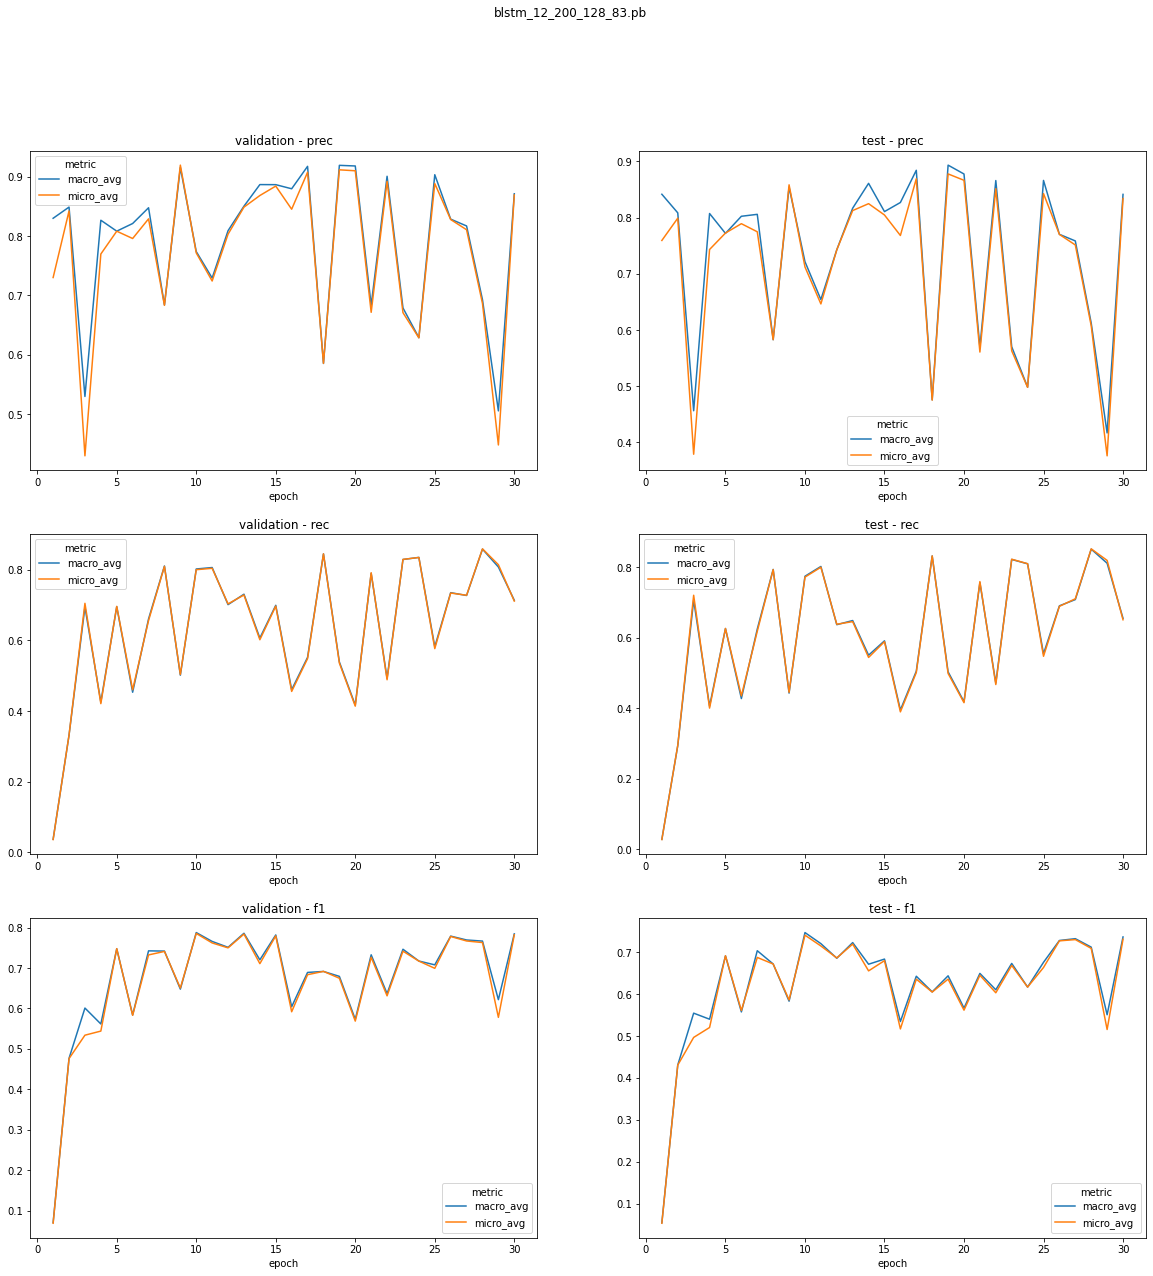

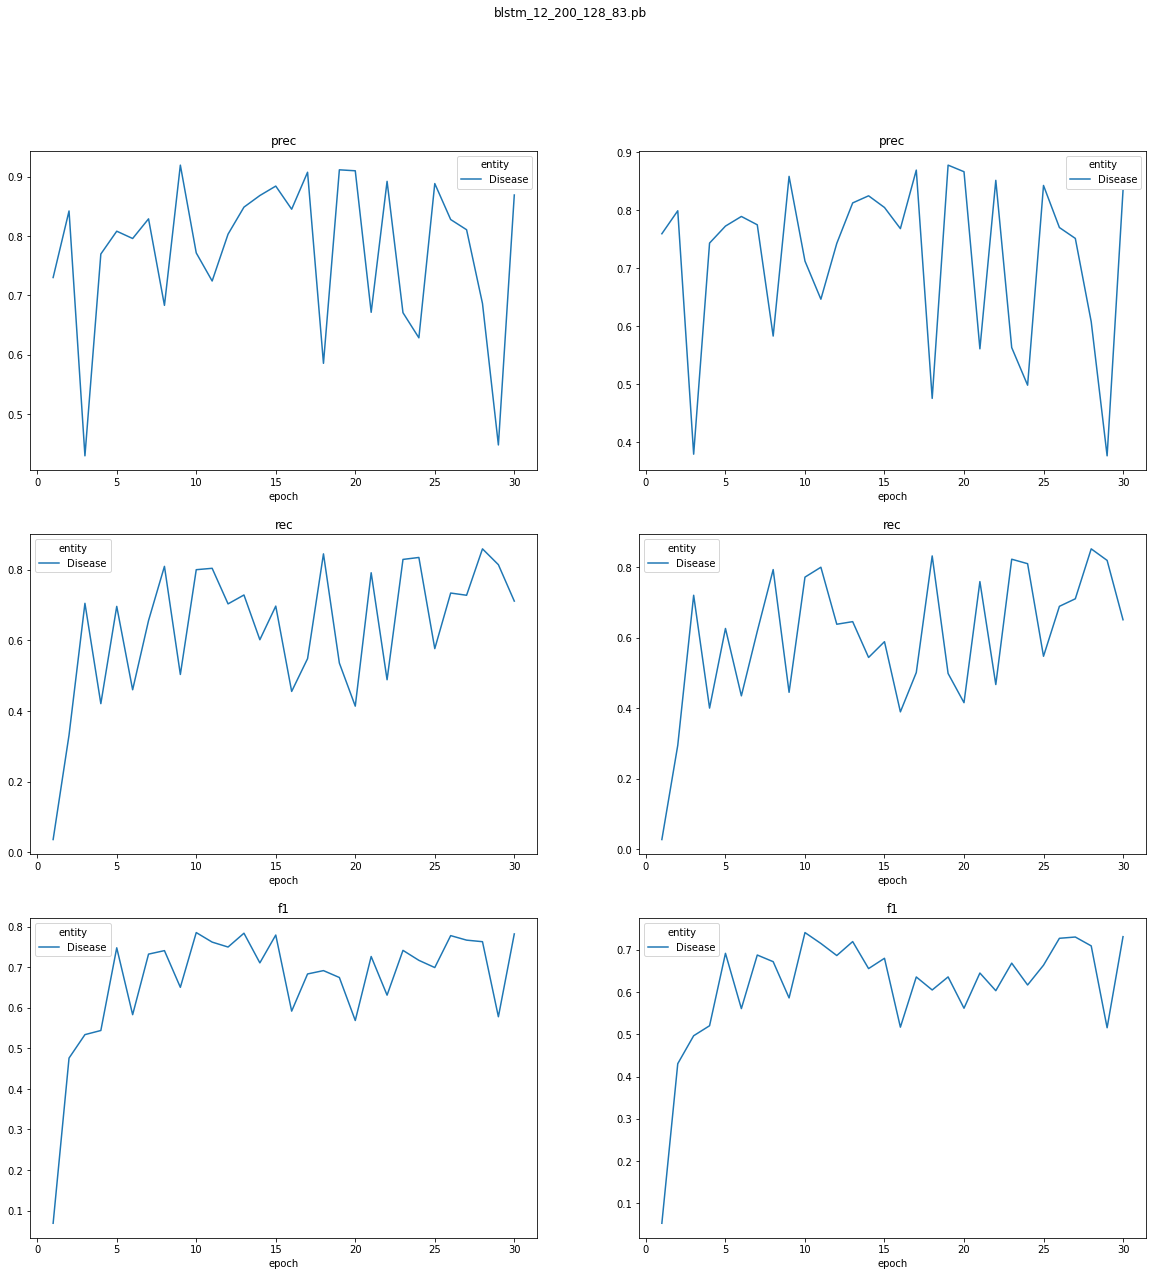

In [24]:
import ner_log_parser
%matplotlib inline
ner_log_parser.get_charts(f"./ner_logs/{log_file}")


### Plotting Loss

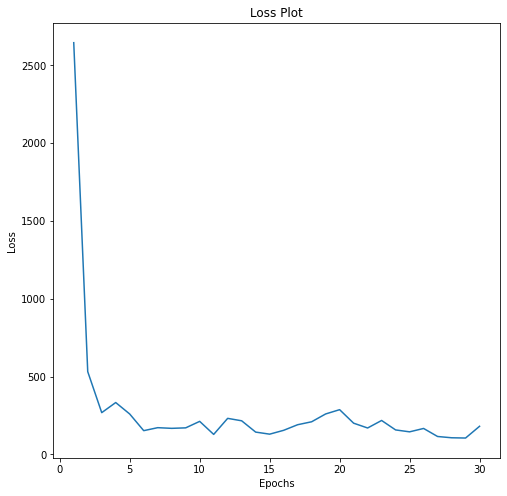

In [25]:
ner_log_parser.loss_plot(f"./ner_logs/{log_file}")

### Evaluate Model

In [26]:
pred_df = ner_model.stages[1].transform(test_data)

In [27]:
pred_df.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

In [28]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

evaler = NerDLMetrics(mode="full_chunk", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+-----+-----+-----+-----+---------+------+------+
| entity|   tp|   fp|   fn|total|precision|recall|    f1|
+-------+-----+-----+-----+-----+---------+------+------+
|Disease|537.0|369.0|167.0|704.0|   0.5927|0.7628|0.6671|
+-------+-----+-----+-----+-----+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.6670807453416149|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.6670807453416149|
+------------------+

None


In [29]:
evaler = NerDLMetrics(mode="partial_chunk_per_token", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+------+-----+-----+------+---------+------+------+
| entity|    tp|   fp|   fn| total|precision|recall|    f1|
+-------+------+-----+-----+------+---------+------+------+
|Disease|1261.0|361.0|236.0|1497.0|   0.7774|0.8424|0.8086|
+-------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8085924975953831|
+------------------+

None
+-----------------+
|            micro|
+-----------------+
|0.808592497595383|
+-----------------+

None


In [30]:
from sklearn.metrics import classification_report

predictions = pred_df.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(predictions['ground_truth'], predictions['prediction'], digits=4))

              precision    recall  f1-score   support

   B-Disease     0.6413    0.8206    0.7200       708
   I-Disease     0.8017    0.7275    0.7628       789
           O     0.9859    0.9785    0.9822     16804

    accuracy                         0.9616     18301
   macro avg     0.8096    0.8422    0.8216     18301
weighted avg     0.9646    0.9616    0.9626     18301



## Model Test

In [31]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

tokenizer = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

clinical_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

loaded_ner_model = MedicalNerModel.load("/content/drive/MyDrive/YL/models/NER_20epoch_64b")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverter()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence_detector,
        tokenizer,
        clinical_embeddings,
        loaded_ner_model,
        converter])

prediction_model = ner_prediction_pipeline.fit(spark.createDataFrame([['']]).toDF("text"))

from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [36]:
# this sample is from mtsamples.com

text = """
FAMILY HISTORY:
No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one family member, a sister, with history of cancer.
REVIEW OF SYSTEMS:
Complete review of systems negative except as in pulmonary as noted above. The patient also reports occasional numbness and tingling of her left arm.
PHYSICAL EXAMINATION
VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and oxygen saturation 97%.
GENERAL: Positive nonproductive cough and pain with coughing.
HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are clear.
NECK: Supple. No lymphadenopathy. No masses.
RESPIRATORY: Pleural friction rub is noted.
GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly.
EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal pulses in all extremities.
SKIN: No breakdown or lesions. No ulcers.
NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and time.
LABORATORY DATA:
Labs are pending.
HOSPITAL COURSE:
The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March 2005 when she first sought medical attention for evidence of pericarditis, which was treated with pericardial window in an outside hospital, at that time she was also found to have mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy, already shows bilateral plural effusions. The patient improved clinically after the pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained from the pericardectomy in March 2006, which was diagnostic of mesothelioma. At this time, chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies, which were performed, which revealed epithelioid malignant mesothelioma. The patient was then stained with a PET CT, which showed extensive uptake in the chest, bilateral pleural pericardial effusions, and lymphadenopathy. She also had acidic fluid, pectoral and intramammary lymph nodes and uptake in L4 with SUV of 4. This was consistent with stage III disease. Her repeat echocardiogram showed an ejection fraction of 45% to 49%. She was transferred to Oncology service and started on chemotherapy on September 1, 2007 with cisplatin 75 mg/centimeter squared equaling 109 mg IV piggyback over 2 hours on September 1, 2007, Alimta 500 mg/ centimeter squared equaling 730 mg IV piggyback over 10 minutes. This was all initiated after a Port-A-Cath was placed. The chemotherapy was well tolerated and the patient was discharged the following day after discontinuing IV fluid and IV. Her Port-A-Cath was packed with heparin according to protocol.
DISCHARGE MEDICATIONS:
Zofran, Phenergan, Coumadin, and Lovenox, and Vicodin
"""

In [37]:
from sparknlp_display import NerVisualizer

result = light_model.fullAnnotate(text)[0]

visualiser = NerVisualizer()

visualiser.display(result, label_col='ner_chunk', document_col='document')